<a href="https://colab.research.google.com/github/mollah2022/Neural-Network/blob/main/Genetic_Disorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Prepared_Dataset_new"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
# ==============================
# Load Data
# ==============================
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 107 files belonging to 3 classes.
Using 86 files for training.
Found 107 files belonging to 3 classes.
Using 21 files for validation.
Classes: ['test', 'train', 'val']


In [ ]:
# ==============================
# Data Augmentation (Strong)
# ==============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1,0.1),
    layers.RandomContrast(0.1)
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# ==============================
# Load Pretrained ResNet50
# ==============================
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE+(3,)
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names),
                       activation="softmax",
                       kernel_regularizer=regularizers.l2(0.01))(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ==============================
# Callbacks
# ==============================
checkpoint_cb = keras.callbacks.ModelCheckpoint("ResNet50_best.h5", save_best_only=True, monitor="val_accuracy")
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:

# ==============================
# Train Base Model
# ==============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1635 - loss: 2.5952

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.1750 - loss: 2.5493 - val_accuracy: 0.2857 - val_loss: 1.7432 - learning_rate: 1.0000e-04
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.2568 - loss: 2.0891 - val_accuracy: 0.2857 - val_loss: 1.5565 - learning_rate: 1.0000e-04
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2624 - loss: 2.0099

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.2607 - loss: 2.0099 - val_accuracy: 0.3333 - val_loss: 1.3934 - learning_rate: 1.0000e-04
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2545 - loss: 1.9090

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 10s/step - accuracy: 0.2606 - loss: 1.9200 - val_accuracy: 0.4286 - val_loss: 1.2593 - learning_rate: 1.0000e-04
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3870 - loss: 1.5591

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.3891 - loss: 1.5759 - val_accuracy: 0.5238 - val_loss: 1.1558 - learning_rate: 1.0000e-04
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 12s/step - accuracy: 0.3928 - loss: 1.7276 - val_accuracy: 0.4762 - val_loss: 1.0829 - learning_rate: 1.0000e-04
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.4086 - loss: 1.6431 - val_accuracy: 0.5238 - val_loss: 1.0341 - learning_rate: 1.0000e-04
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4883 - loss: 1.3569 

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.4941 - loss: 1.3407 - val_accuracy: 0.5714 - val_loss: 1.0036 - learning_rate: 1.0000e-04
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.5253 - loss: 1.2936 - val_accuracy: 0.5238 - val_loss: 0.9865 - learning_rate: 1.0000e-04
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 10s/step - accuracy: 0.3968 - loss: 1.7131 - val_accuracy: 0.5714 - val_loss: 0.9772 - learning_rate: 1.0000e-04


In [ ]:
# ==============================
# Fine-Tuning
# ==============================
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

model.save("ResNet50_final_finetuned.h5")
print("✅ Fine-tuned model saved!")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 18s/step - accuracy: 0.5837 - loss: 1.1259 - val_accuracy: 0.5714 - val_loss: 0.9778 - learning_rate: 5.0000e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 16s/step - accuracy: 0.6070 - loss: 1.0538 - val_accuracy: 0.5238 - val_loss: 0.9852 - learning_rate: 5.0000e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.6011 - loss: 1.0687 - val_accuracy: 0.5238 - val_loss: 1.0060 - learning_rate: 5.0000e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 17s/step - accuracy: 0.6614 - loss: 0.8817 - val_accuracy: 0.5238 - val_loss: 1.0335 - learning_rate: 5.0000e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.6889 - loss: 0.8231 - val_accuracy: 0.5238 - val_loss: 1.0476 - learning_rate: 2.5000e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 16s/step - accuracy: 0.6985 - loss: 0.9250 - val_accuracy: 0.5714 - val_loss: 1.0574 - learning_rate: 2.5000e-05


✅ Fine-tuned model saved!


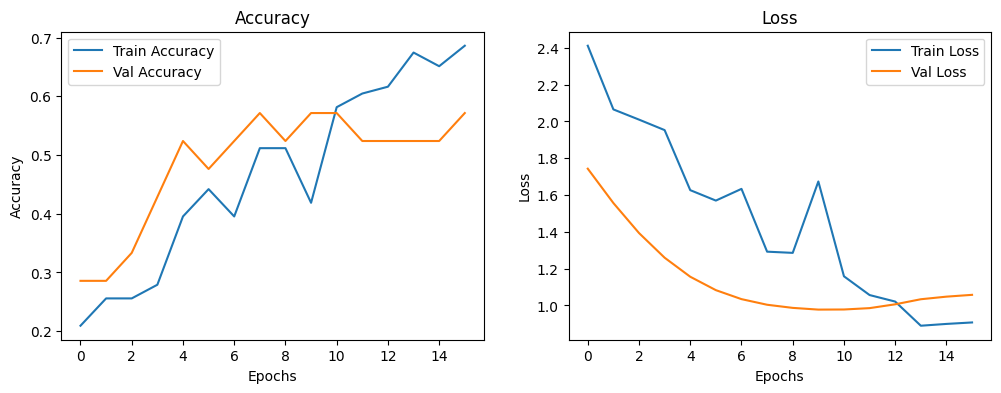

In [ ]:

# ==============================
# Plot Accuracy & Loss
# ==============================
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history, history_fine)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


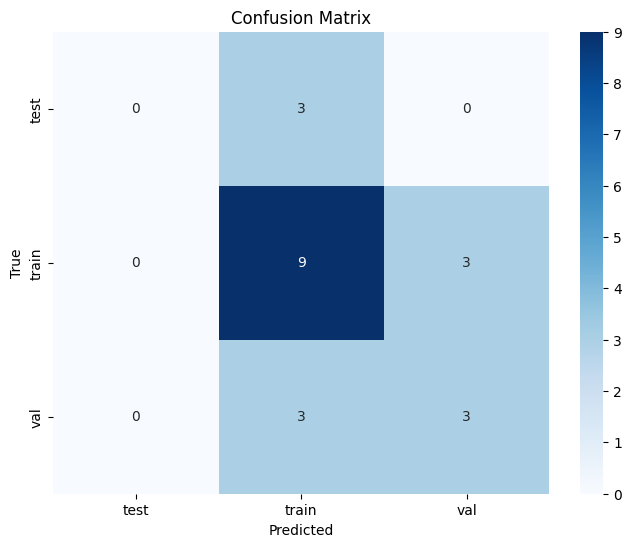

Classification Report:
              precision    recall  f1-score   support

        test       0.00      0.00      0.00         3
       train       0.60      0.75      0.67        12
         val       0.50      0.50      0.50         6

    accuracy                           0.57        21
   macro avg       0.37      0.42      0.39        21
weighted avg       0.49      0.57      0.52        21



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ==============================
# Confusion Matrix & Classification Report
# ==============================
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

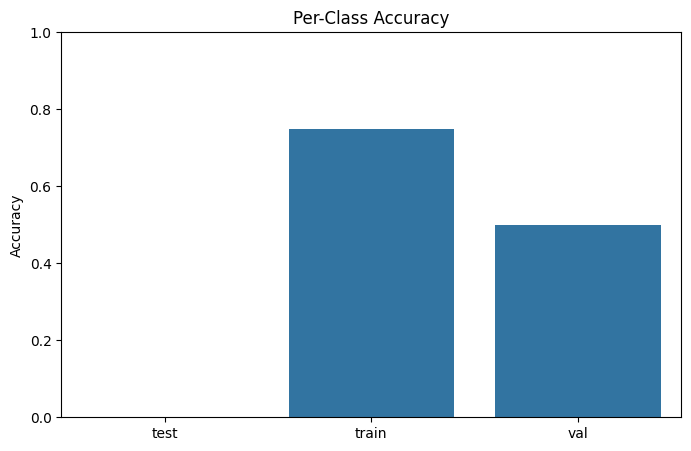

In [ ]:
# ==============================
#  Per-Class Accuracy Bar Plot
# ==============================
import pandas as pd

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_acc = np.diag(cm_normalized)

plt.figure(figsize=(8,5))
sns.barplot(x=class_names, y=per_class_acc)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

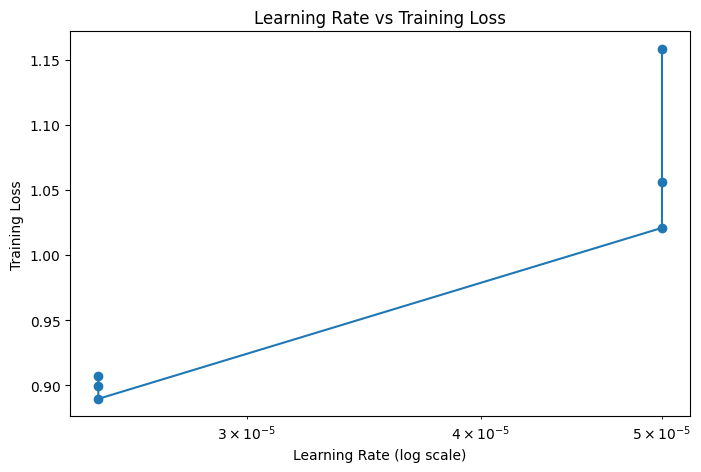

In [ ]:
# ==============================
#  Learning Rate vs Loss Curve
# ==============================
lrs = [5e-5 * (0.5 ** (i // 3)) for i in range(len(history_fine.history['loss']))]
plt.figure(figsize=(8,5))
plt.plot(lrs, history_fine.history['loss'], marker='o')
plt.xscale('log')
plt.title("Learning Rate vs Training Loss")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Training Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


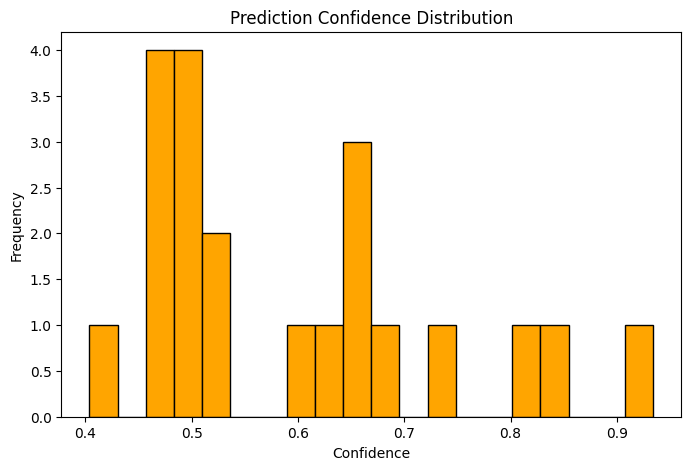

In [ ]:
# ==============================
# Prediction Confidence Distribution
# ==============================
all_preds = np.concatenate([model.predict(images) for images, _ in val_ds])
confidences = np.max(all_preds, axis=1)

plt.figure(figsize=(8,5))
plt.hist(confidences, bins=20, color='orange', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


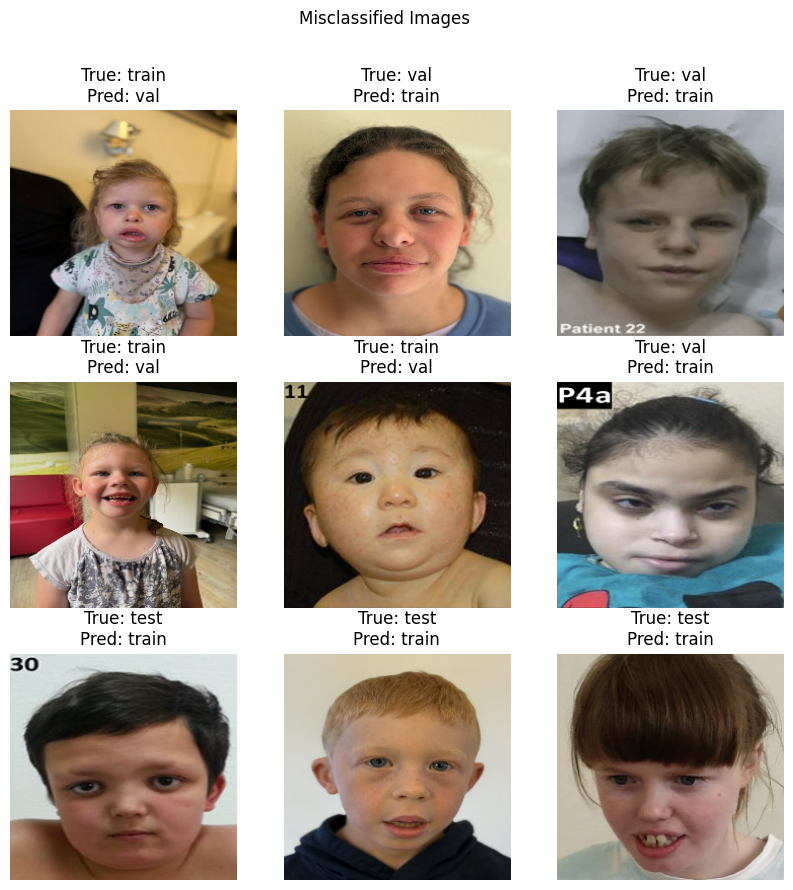

In [ ]:
# ==============================
#  Misclassified Images Visualization
# ==============================
import random

# Convert val_ds to list for easy access
val_images, val_labels = [], []
for images, labels in val_ds.take(5):  # Only few batches
    val_images.extend(images)
    val_labels.extend(labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

preds = model.predict(val_images)
pred_labels = np.argmax(preds, axis=1)

misclassified_idx = np.where(pred_labels != val_labels)[0]
if len(misclassified_idx) > 0:
    sample_idx = random.sample(list(misclassified_idx), min(9, len(misclassified_idx)))

    plt.figure(figsize=(10,10))
    for i, idx in enumerate(sample_idx):
        plt.subplot(3,3,i+1)
        plt.imshow(val_images[idx].astype("uint8"))
        plt.title(f"True: {class_names[val_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis("off")
    plt.suptitle("Misclassified Images")
    plt.show()
else:
    print("✅ No misclassified samples found!")


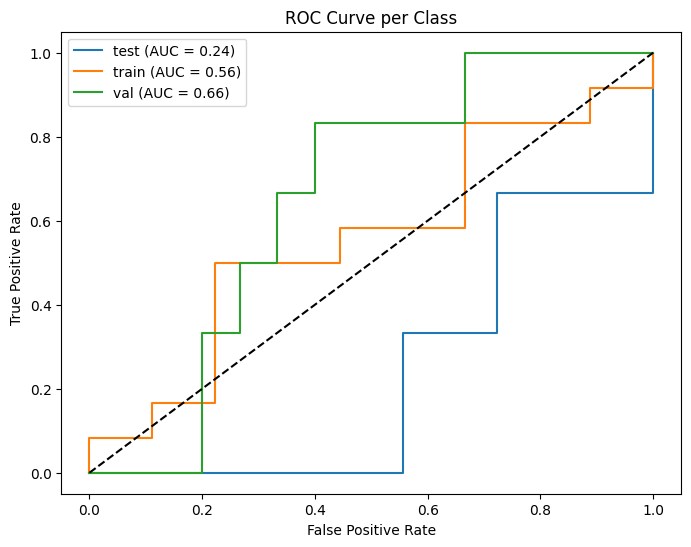

In [ ]:
# ==============================
#  ROC Curve & AUC per Class
# ==============================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
y_pred_prob = np.array(all_preds)
n_classes = len(class_names)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve per Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
# ==============================
# Model Summary Visualization
# ==============================
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file="resnet50_model_architecture.png")
print("📊 Model architecture image saved as 'resnet50_model_architecture.png'")

📊 Model architecture image saved as 'resnet50_model_architecture.png'


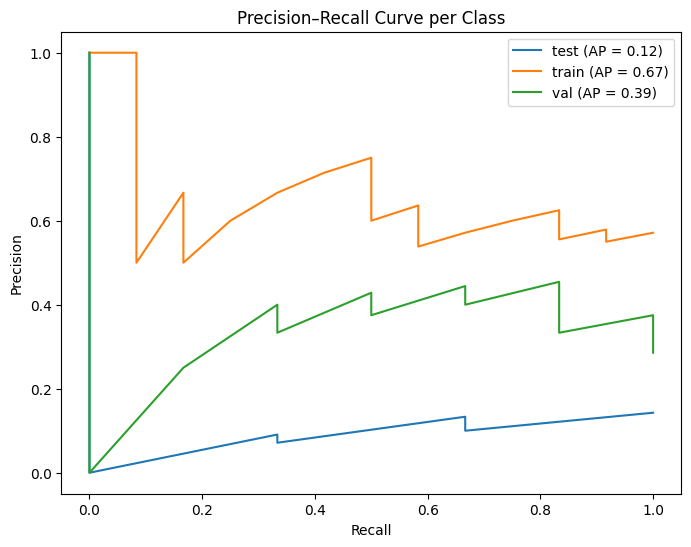

In [ ]:
# ==============================
# 🔟 Precision–Recall Curve
# ==============================
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap:.2f})")

plt.title("Precision–Recall Curve per Class")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
